<a href="https://colab.research.google.com/github/cannonbunny/stock-sentiment-analysis/blob/master/news_to_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## News Processing
- reuters_headlines.csv  
- guardian_headlines.csv 
- cnbc_headlines.csv 

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from datetime import datetime, date, timedelta
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# clean reuter
reuters = pd.read_csv('/content/drive/My Drive/reuters_headlines.csv').dropna()
reuters = reuters[['Time', 'Headlines']]
reuters["Time"] = reuters["Time"].map(lambda time_str: datetime.strptime(time_str, "%b %d %Y"))
min(reuters['Time']), max(reuters['Time'])

(Timestamp('2018-03-20 00:00:00'), Timestamp('2020-07-18 00:00:00'))

In [ ]:
# clean cnbc
def clean_date_format(time_str):
  try:
    return datetime.strptime(time_str, "%d %B %Y")
  except:
    return datetime.strptime(time_str, "%d %b %Y")

cnbc = pd.read_csv('/content/drive/My Drive/cnbc_headlines.csv').dropna()
cnbc = cnbc[['Time', 'Headlines']]
cnbc["Time"] = cnbc["Time"].map(lambda x: x.split(",")[1].strip())
cnbc["Time"] = cnbc["Time"].map(lambda x: x.replace("Sept ", "September ") if "Sept" in x else x)
cnbc["Time"] = cnbc["Time"].map(clean_date_format)
min(cnbc['Time']), max(cnbc['Time'])

(Timestamp('2017-12-22 00:00:00'), Timestamp('2020-07-17 00:00:00'))

In [ ]:
# clean guardian
guardian = pd.read_csv('/content/drive/My Drive/guardian_headlines.csv').dropna()
guardian = guardian[guardian.Time.str.len()!=6]
guardian = guardian[['Time', 'Headlines']]
guardian["Time"] = guardian["Time"].map(lambda time_str: datetime.strptime(time_str, "%d-%b-%y"))
min(guardian['Time']), max(guardian['Time'])

(Timestamp('2017-12-17 00:00:00'), Timestamp('2020-07-18 00:00:00'))

In [ ]:
# union and save
full_data = pd.concat([reuters, guardian, cnbc], ignore_index=True)
full_data.to_csv("/content/drive/My Drive/news_full_data.csv", index=False)

In [ ]:
print("Duration: ", min(full_data["Time"]), "->", max(full_data["Time"]))
print("Days between max_dt and min_dt: ", max(full_data["Time"]) - min(full_data["Time"]))
print("Days with datapoints: ", full_data["Time"].nunique())

Duration:  2017-12-17 00:00:00 -> 2020-07-18 00:00:00
Days between max_dt and min_dt:  944 days 00:00:00
Days with datapoints:  931


In [ ]:
def has_index(headline):
  keywords = ["U.S. economy", "S&P", "Dow", "Nasdaq", "Fed", "stocks", "Wall Street"]
  for word in keywords:
    if word in headline:
      return 1
  return 0

In [ ]:
def get_daily_news(df):
  '''
  Input: df[Time, Headlines, has_index]
  Output: daily_news[date, text]
  '''
  dates = pd.date_range(min(full_data["Time"]),max(full_data["Time"])-timedelta(days=1),freq='d')
  news_list = []
  for date in dates:
    sub_df = df[df["Time"]==date]
    sub_df = sub_df[sub_df["has_index"]==1][:5]
    news_combined = ". ".join(list(sub_df.Headlines))
    news_list.append(news_combined)
  daily_news = pd.DataFrame({"date": dates, "text": news_list})
  return daily_news

In [ ]:
full_data["has_index"] = full_data["Headlines"].map(has_index)
daily_news = get_daily_news(full_data)

In [ ]:
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%d-%m-%Y')

stock = pd.read_csv("/content/drive/My Drive/GSPC.csv", parse_dates=['Date'], date_parser=dateparse)
stock = stock.iloc[:,[0,1]]
daily_news_2 = daily_news.join(stock.set_index('Date'), on='date')
daily_news_2 = daily_news_2.dropna(axis=0, subset=['y_Open'])
daily_news_2 = daily_news_2[['date','text']].reset_index(drop=True)

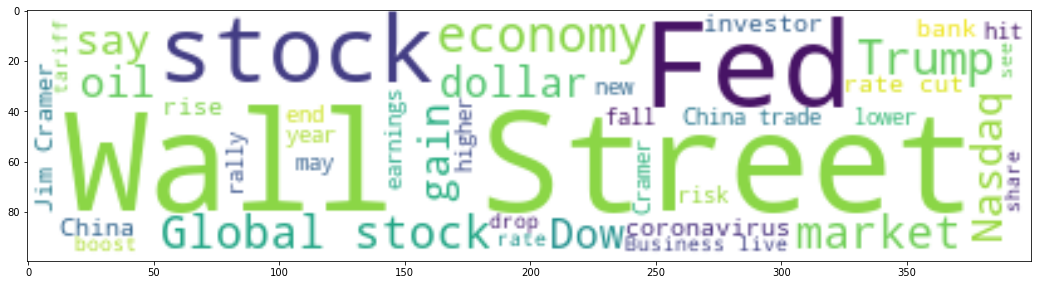

In [ ]:
from wordcloud import WordCloud
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (18,24))
wordcloud = WordCloud(background_color='white', min_font_size = 3,  max_words = 40 , width = 400 , height = 100).generate(" ".join(daily_news_2['text']))
plt.imshow(wordcloud,interpolation = 'bilinear')

# Predict Sentiment

In [ ]:
!pip install tensorflow_text
!pip install tf-models-official

In [ ]:
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
from keras.utils import to_categorical
from official.nlp import optimization  # to create AdamW optmizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
num_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpu)
if num_gpu > 0:
    tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [ ]:
model = keras.models.load_model('/content/drive/My Drive/FISA_model3', compile=False)

In [ ]:
pred = model.predict(daily_news_2["text"])

In [ ]:
pred_2 = pd.DataFrame(data=pred,
          index=np.array(range(0, len(pred))),
          columns=np.array(range(0, 3)))
pred_2 = pred_2.join(daily_news_2)
pred_2 = pred_2[['date',0,1,2]]

In [ ]:
# 0: negative, 1: neutral, 2: positive
pred_2

,date,0,1,2
0,2017-12-18,0.000468,0.999022,0.000510
1,2017-12-19,0.000468,0.999022,0.000510
2,2017-12-20,0.000468,0.999022,0.000510
3,2017-12-21,0.000468,0.999022,0.000510
4,2017-12-22,0.148498,0.849903,0.001599
...,...,...,...,...
644,2020-07-13,0.287505,0.692762,0.019734
645,2020-07-14,0.399062,0.258508,0.342430
646,2020-07-15,0.000652,0.029649,0.969699
647,2020-07-16,0.981245,0.015621,0.003134


In [ ]:
pred_2.to_csv("/content/drive/My Drive/FISA_pred.csv")